# Project 2: Uncles and Uncles Rewards
- Model a Blockchain that uses uncles and uncle rewards
- Model rewarding mechanism to reward uncle block creators
- Model selfish mining (only one attacker) in this blockchain

Try to answer the following questions with your experiment:
1. How do uncles improve the fairness of the blockchain? For this, you should compare the outcome of miners with and without uncles.
2. What is the impact of uncles on selfish mining? Is selfish mining more profitable with uncles?
3. What does it mean in this model for the selfish mining attack to be profitable?

 Since more miners will get rewards for mining, even if they don't finish a block that is part of the longest chain, they will be rewarded for it. So the time and energy used for that block will not be as wasted, and it seems more rewarding to mine. Show net money with and without uncle rewards to display point. The concept of it is for fairness, but may encourage selfish mining. 

## Introduction

Blockchains are currently a hot topic of research, and they have their fair share of problems. In this project, we will explore the concepts of uncles and uncles rewards in blockchains. Uncles is a measure that can be implemented in a blockchain to improve fairness, and it functions by giving some money to miners who lose their mined blocks in a fork while also giving some incentive to the other miners to include this reward in their own blocks. This project assumes knowledge of the implementation of proof-of-work and a full blockchain.

### Uncles and uncles reward

An uncle is essentailly a block that was discarded because it ended up in a fork that didn't grow to be the longest chain. It is called uncle because it is a block that builds on another block, it's parent, which is also the parent of another block, it's sibling, that ended up in the longest chain, and therefore has a child block that can be regarded as the nephew of that first block. This means it only becomes an uncle block when it has a uncle/nephew relationship with a block in the longest chain. The idea is that the miner who mined the uncle block should also get some reward for the effort they spent to mine that block, and this should in theory increase the fairness of the blockchain.

![Uncle and nephew blocks](Figures/UncleBlock.png?raw=true "Uncle and nephew blocks")

In order to make miners include a uncle reward in the blocks they mine, it is also important that the nephew also gets some reward. So in total, two new rewards/transactions are added, the nephew reward and the uncle reward, in order to help aleviate the loss incured when mining a block that ends up in a discarded fork.

There are multiple different implementations possible for this kind of reward system, with differences like:

- How many uncles can a single nephew give rewards to?
- How far apart in the chain can two blocks be while still being considered uncle/nephew?
- If an uncle reward can be given to a block that's further apart than a direct uncle, should the reward be the same? If not, how much should it decrease by?
- How much is the uncle reward?
- How much is the nephew reward?
- Can an uncle reward be given to child blocks of an uncle, or just the uncle?

And all of these parameters may affect the fairness. In addition to that, they may have unintended consequenses, like encouraging mining on a fork that isn't the longest, if implemented wrong.

#### Fairness
It is important to define fairness before we continue: the fairness for an individual miner is defined as the portion of the reward given to them compared to the portion of mining power they have. Which is the same as their ratio of reward to power, compared to the total ratio of the same.
 
$Fairness(miner) = \frac{\text{miner reward}}{\text{total reward}} / \frac{\text{miner power}}{\text{total power}} = \frac{\text{miner reward} }{\text{miner power}} / \frac{\text{total reward}}{\text{total power}}$

Using this measure, the closer the value is to 1, the more fair the chain is for that particular miner. It is important to note that this measure is defined on the interval $\left[0, \frac{\text{total power}}{\text{miner power}}\right].$ The fairness changes equally when increasing or decreasing the reward, in absolute terms, not relative. That means that when increasing the reward by some amount $\text{k}$ coins, it changes the fairness the same amount as if the reward had been decreased by $\text{k}$ coins. This is in contrast to a relative fairness measure where increasing the reward by a factor of $\text{x}$ would have the same amount of dividing the reward by $\text{x}.$ This means that 

<!--TODO rewrite-->
To figure out how fair the chain as a whole is, we could take the average of the fairness for each miner, but this would be a rather bad measure, since the increased portion of reward for one miner would always result in less for the others, making the average always hover around 1, even when one miner is hoggin a much larger portion than it should. Instead, a cumulative measure of the absolute distance from totally fair, $Fairness = 1$, for each miner would be more useful, however this would be a measure of unfairness, not fariness. Defining the fairness as $\frac{1}{\text{unfairness}}$ would result in a value that is hard to manage between 0 and infinity, virtually useless, so instead we are simply going to use $-\frac{\text{unfairness}}{\text{number of miners}}$ as the measure for fairness, even though this value is then between 0 and -infinity.



<!-- $Fariness = \frac{P(t|f) P(f)}{P(t)} = \frac{P(t|f) P(f)}{\sum_{f' \in \mathcal{F}} P(t|f')P(f')},$ -->

### Imports
We extracted the drawBlockchain() function from the notebook and it is imported into this notebook 

In [1]:
#Import statements
from draw_blockchain import show
import hashlib as hasher
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from dataclasses import dataclass
import functools
import operator
import pandas as pd
from scipy import stats

### Hash function
Copy of the hashing functions used in the lecture 5 notebook. This could have been abstracted to random numbers of some kind, since we are not interesed in the hasing. The mining power is just defined as how many _tries_ each round the miners get at solving the pow. However we did not focus on this, and therefore it is just as in the lectures.

In [2]:
def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def hash(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    #print(type(inputbytes))
    hash_obj.update(inputbytes)
    return hash_obj.hexdigest()

def numberOfInitZeros(hashStr):
    count = 0
    for i in range (0 , len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

### Block
Same as in the lecture notebook

In [3]:
class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0, blockchain=None):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0 , "0", blockchain, genesis=True)
            self.height = 0
            self.color = "#AEF751"
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
            self.color = creator.color
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data + self.creator.name + self.previous_hash + str(self.nonce))

    def print(self):
        print(self.data + " "+ self.creator.name + " " + str(self.height))

### Blockchain
Same as in the lecture notebook, but we added some helper functions, end_with_fork(), inlongestChain(block) and forks(), where the latter two are are to be used after simulation to get information about the state of the chain, like blocks part of the longest chain. forks() was used to monitor how many forks the blockchain ended up with in the end, so we could tune the parameters, and we decided that the blockchain could not end with a fork, so the first additional function checks this.

In [4]:
class Blockchain:
    def __init__(self, genesis_data, difficulty, static=False):
        self.chain = []
        self.difficulty = difficulty
        self.size = 0
        self.static = static
        self.chain.append(Block(genesis_data, blockchain=self))

    def longestChain(self, static=-1):
      max = self.chain[0].height
      for block in self.chain:
          if block.height > max:
                max = block.height
      maxes = [block for block in self.chain if block.height == max]
      static %= len(maxes)
      r = maxes[static:static+1] if static >= 0 else random.choices(maxes, k=1)
      return r[0]
    
    def ends_with_fork(self):
        max = self.chain[0].height
        r = False
        for block in self.chain:
            if block.height == max: r = True
            if block.height > max:
                max = block.height
                r = False
        return r
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1
        
    def print(self):
        for block in self.chain:
            block.print()
            print("________")

    def hasFork(self):
        for block1 in self.chain:
            for block2 in self.chain:
                if block1!=block2 and block1.height == block2.height:
                    return True
        return False

    def checkMiner(self, miner):
      last = self.longestChain(miner.static)
      count = 0
      while last!=None:
          if last.creator == miner:
                count += 1
          last = last.previous
      return count
    
    def inlongestChain(self, block):
          last = self.longestChain()
          while last!= None:
                if last == block:
                        return True
                last = last.previous
          return False
          
    def forks(self):
        fork_list = []
        last = self.longestChain()
        while last != None:
            for child in last.children:
                if not self.inlongestChain(child):
                    length = 1
                    forkblock = child
                    while forkblock.children:
                        length += 1
                        forkblock = forkblock.children[0]
                    fork_list.append(length)
            last = last.previous
        return fork_list


## Miners
Same as the lecture notebook, but we added some more attributes to them, like _reward_, and _uncles_ that we calculate after the simulation.

### Normal miner

In [5]:
class Miner:
    def __init__(self, miningPower, name, blockchain=None, genesis=False):
        self.miningPower = miningPower
        self.nonce = 0 if blockchain.static else random.randint(0,100000) #original one
        # self.nonce = 0
        self.name = name
        self.blockchain = blockchain
        self.color = "#7EDBF6"
        self.uncles = 0
        self.nephews = 0
        self.blocks = 0
        self.static = sum([ord(c) for c in name]) if blockchain.static else -1
        if self.blockchain != None and not genesis:
            self.lastBlock = blockchain.longestChain(static=self.static)
    
    def UpdateLast(self):
        latest = self.blockchain.longestChain(static=self.static)
        if latest.height > self.lastBlock.height:
              self.lastBlock = latest

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= self.blockchain.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1


### Selfish miner
Added finish method

In [6]:
class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False
        self.color = "#F59AEE"

    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks) > 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True
    
    def Finish(self):
        if len(self.privateBlocks) > 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
            self.privateBlocks = []

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= self.blockchain.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

## Main program

### Run function
Based on the main function from the lecture notebook we altered it and made our own run() function with different parameters so we could easily check different configurations. Everything from mining power to number of miners is changable. After the chain has been simulation, we then go through each of them and reward the miners.

In [7]:
def run(
        difficulty=10,
        num_miners=10,
        num_selfish_miners=0,
        mining_power=10,
        mining_power_selfish=15,
        genesis_data="0",
        num_blocks = 30,
        miners = [],
        static=False
    ):
    bc = None
    bc = Blockchain(genesis_data , difficulty, static)
    miners = [Miner(p, "m"+ str(i), bc) for i,p in enumerate(miners)]
    selfish = []
    len_miners = len(miners)
    for i in range(num_miners):
        miners.append(Miner(mining_power ,"m"+str(len_miners+i), bc))
    for i in range(num_selfish_miners):
        selfish.append(SelfishMiner(mining_power_selfish ,"s"+str(i), bc))
    while bc.chain[-1].height < num_blocks or bc.ends_with_fork():
        for s in selfish:
            s.PoWSolver()

        for m in miners:
            m.PoWSolver()

        for s in selfish:
            s.UpdateLast()

        for m in miners:
            m.UpdateLast()

    # Making sure the private blocks are published.
    for s in selfish:
        s.Finish()

    for s in selfish:
        s.UpdateLast()

    for m in miners:
        m.UpdateLast()
    
    calculate_blocks(bc)
    return bc, miners, selfish

def calculate_blocks(bc):
    last_block = bc.chain[-1]
    while last_block.previous is not None:
        last_block.creator.blocks += 1
        grandparent = last_block.previous.previous
        if grandparent is not None and len(grandparent.children) > 1:
            for uncle in grandparent.children:
                if uncle != last_block.previous:
                    uncle.creator.uncles += 1
                    last_block.creator.nephews += 1
        last_block=last_block.previous

### Fairness function

In [8]:
def fairness(df, reward=10, uncle_reward=3, nephew_reward=2):
    total_power = df[["power"]].sum().power
    rewards = df["blocks"] * reward + df["uncles"] * uncle_reward + df["nephews"] * nephew_reward
    total_reward = rewards.sum()
    fairness_miners = (rewards/total_reward)/(df["power"]/total_power)
    unfairness = (fairness_miners-1).abs()
    fairness_miners.rename("fairness", inplace=True)
    relative_fairness = df.join(fairness_miners)
    relative_fairness = relative_fairness.apply(lambda row: row.fairness if row.fairness <= 1 else 1-(row.fairness*row.power/total_power), axis=1)
    return fairness_miners, unfairness, relative_fairness

### Dataclass
Used for formatting the run function output. Returns a dataframe that we can easily get the information we need, after simulating.

In [9]:
@dataclass
class Stats:
    name: str
    blocks: int
    uncles: int
    nephews: int
    power: int

# Transform irregular 2D list into a regular one.
def transform(nested_list):
    regular_list = []
    for e in nested_list:
        if type(e) is list:
            regular_list.append(e)
        else:
            regular_list.append([e])
    return functools.reduce(operator.iconcat, regular_list, [])

def get_stats(*miners):
    if len(miners) == 0:
        return []
    stats = []
    transformed_miners = transform(miners)
    
    for m in transformed_miners:
        stats.append(Stats(
            m.name,
            m.blocks,
            m.uncles,
            m.nephews,
            m.miningPower
        ))
    return pd.DataFrame(stats)

### Average function
Since we are dealing with randomness, the individual results of each run vary tons, so much in fact that they do not give results that we can base our answers on. One simulation could give miner number 8 (out of 10, and all equal) a reward of 200 out of 100 blocks with blockreward 10, which is twice the _correct_ amount each miner should get, if they were equal and we wanted an equal distribution. Therefore we made an average function that uses the run() function n amount of times, and divides the results based on number of simulations. This gives a better representation of how the blockchain rewards different miners for different configurations. 

In [10]:
def getavg(tests, run_func, **kwargs):
    args = set(kwargs)
    num_nodes = 0
    if "num_blocks" in kwargs:
        miner_args = {"num_miners","miners","num_selfish_miners"}.intersection(args)
        if miner_args:
            for arg in miner_args:
                val = kwargs.get(arg)
                num_nodes += len(val) if type(val) == list else val
        dfout = pd.DataFrame()
        for i in range(tests):
            bc, m, s = run_func(**kwargs)
            dfa = get_stats(s,m)
            if dfout.empty:
                dfout = dfa
            else:
                dfout[['blocks', 'uncles', 'nephews']] += dfa[['blocks', 'uncles', 'nephews']]
        dfout[['blocks', 'uncles', 'nephews']] = dfout[['blocks', 'uncles', 'nephews']] / tests
    else:
        dfout = pd.DataFrame()
    return dfout

### BarPlot
Two bar plot functions, one for a single data source, and one for two groups that we would want to compare

In [11]:
def bar2groups(group1, group2, names=None, label1=None, label2=None, title=None):
    if len(group1.tolist()) != len(group2.tolist()):
        print("groups must be the same length")
        return ""
    else:
        width = 0.35
        xpos = np.arange(len(group1))
        fig, ax = plt.subplots()
        ax.bar(xpos - width/2, group1, width, label= label1)
        ax.bar(xpos + width/2, group2, width, label= label2)

        ax.set_ylabel("Rewards")
        ax.set_title(title)
        ax.set_xticks(xpos)
        ax.set_xticklabels(names)
        ax.legend()
        fig.tight_layout()
        plt.show()

In [12]:
def barplot(vals, names, label, title):
        plt.bar(names, vals)
        plt.xlabel(label)
        plt.ylabel("Rewards")
        plt.title(title)
        plt.show()

### Static chain

In order to reliably test the code, we decided that it was neccessary to implement a version of the blockchain without any randomness. This is achieved with the static parameter for the run method. Normally, the miners will pick randomly between block of the same height to mine on top of, but for the static chain, they will instead use their name to calculate an index (using the mod operator and sum(ord)) of their name) to select which block to mine on top of. 

Below you can see a chain that has 8 blocks in the longest, with two forks. It will always be that specific chain with the same miners on the same blocks, i.e. miner 7 will always get block 2. The chain has two forks, one of length 1 and one of length 2. We have implemented a uncle reward where a uncle who gets referenced will get a static reward, and the one referencing it will get a smaller nephew reward. In the case below, only two blocks should receive uncle rewards, the block miner 1 made that is the first in the first fork, and the block made by miner 7, in the second fork. This was easy to debug and below you can see the resulting dataframe.


In [19]:
bc, m, s = run(mining_power=40, num_blocks=8, static=True)
show(bc)
print(get_stats(m))

  name  blocks  uncles  nephews  power
0   m0       1       0        0     40
1   m1       0       1        0     40
2   m2       0       0        0     40
3   m3       1       0        0     40
4   m4       1       0        0     40
5   m5       1       0        0     40
6   m6       1       0        1     40
7   m7       2       1        1     40
8   m8       0       0        0     40
9   m9       1       0        0     40


## Results

### Baseline

To begin with we ran the blockchain with 15 different miners and 100 blocks mined in total. This was done 100 times and we normalised the rewards for each miner and plotted it.
This showed us that all the miners had _about_ the same amount of reward when mining for a long time, on many blocks.
 We can now conclude that the blockchain is somewhat fair, because same amount of mining power roughly equals same reward.

We also did this with a single miner that had 3X the mining power of the other nodes to see if there were any difference. 
The miner with 3X mining power got about 3x the reward of a "_average_" miner. This also works as intended.

In [47]:
df_nobig = getavg(10, run, num_blocks=100, num_miners=15)
df_big = getavg(10, run, num_blocks=100, num_miners=14, miners=[30]) # [1,12] forks avg at 4/5 forks each chain

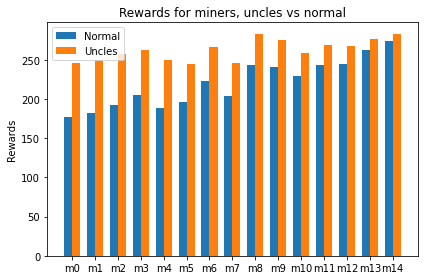

In [16]:
barplot(df2["reward"],df2["reward"]+ df2["uncle_reward"],df2["name"],"Normal", "Uncles","Rewards for miners, uncles vs normal")

### Uncle BlockChain

We chose to reward the miners after running the simulation because of trouble with debugging and finding a good way of implementing uncle in the simulation. In the last part of the run function, implemented above the dataclass section, you can see that there is a while loop at the end of the function. This part adds uncle rewards if the uncle reward is set (uncle_reward > 0). It goes through the chain backwards, blockwise, and if a _grandparent_ has more than one child it will reference each of those not in the chain. That block's creator will then receive the nephew reward times how many uncles it referenced, and the creators of those uncle blocks will receive the uncle reward. The miners have an attribute for uncle reward and this is implemented in the dataframe that will be returned by the get_stats() function.

```python
def run(
    ...
    while last_block.previous is not None:
        last_block.creator.reward += reward
        last_block.creator.blocks += 1
        if uncle_reward > 0:
            grandparent = last_block.previous.previous
            if grandparent is not None and len(grandparent.children) > 1:
                for uncle in grandparent.children:
                    if uncle != last_block.previous:
                        uncle.creator.uncle_reward += uncle_reward
                        uncle.creator.uncles += 1
                        last_block.creator.uncle_reward += nephew_reward
                        last_block.creator.nephews += 1
        last_block=last_block.previous
    return bc, miners, selfish
```

### Configuration of rewards

To find a configuration that gives good fairness we calculate the fairness for a variety of configurations. We make the assumption that the block reward should be highest, the uncle reward should be smaller, but not very small, while the nephew reward should be very small in comparison. As a starting point, ethereum can be used, which has a ratio of 28:20:1 for reward, uncle reward and nephew reward [(source)](https://medium.com/@ShariHunt/there-are-two-uncle-rewards-a67e06fa17de). The numbers 100, 30 and 10 here are picked in such a way that that configuration is possible, while allowing for some more exploration of other configurations.

In [ ]:
unfairnesses = {}
fairnesses = {}
for r in range(1, 50):
    for ur in range(r-1):
        for nr in range(min(ur,10)):
            _, unfairness, relative = fairness(df_nobig, r, ur, nr)
            s = f"{r},{ur},{nr}"
            unfairnesses[s] = np.average(unfairness)
            fairnesses[s] = np.average(relative)

We examine both the unfairness and the relative fairness to see which configuration would make this chain most fair. Only the top 10 are examined, for the sake of simplicity.

In [ ]:
for k in sorted(fairnesses, key=fairnesses.get, reverse=True)[:10]:
    print(k, fairnesses[k])
print("")
for k in sorted(unfairnesses, key=unfairnesses.get, reverse=False)[:10]:
    print(k, unfairnesses[k])

Sample output:\
16,11,0 0.9200181857716104\
32,22,0 0.9200181857716104\
32,22,1 0.9200164820342863\
35,24,0 0.9200155446502\
35,24,1 0.9200139872650831\
19,13,0 0.9200133200133199\
38,26,0 0.9200133200133199\
35,24,2 0.92001243052996\
38,26,1 0.9200118858261523\
41,28,0 0.92001142054618

29,20,0 0.09163095510702561\
16,11,0 0.09163256834489708\
32,22,0 0.09163256834489708\
32,22,1 0.09163576285238004\
35,24,0 0.09163752044754132\
42,29,0 0.091639375117636\
35,24,1 0.09164044054463588\
19,13,0 0.09164169164169163\
38,26,0 0.09164169164169163\
35,24,2 0.09164335942299216

Looking at the results, it is fairly obvious that the nephew reward has little impact on the fairness, and may even lead to less fairness, however this has not been thoroughly examined here. 

We see that a ratio of reward to uncle reward similar to that of ethereum results in highest fairness, and see that the differences between the top 10 are miniscule. Therefor the conclusion is that any of the configurations that are included in both top 10s should be decent. Looking at just the reward and uncle reward, we can see that 32:22 or 35:24 are good options. We want a configuration that is as fair as possible, but it must also include a nephew reward in order to encourage giving uncle rewards. As such, we conclude by using the values 32:22:1 as our reward configuration, since this seemed to be a decent configuration, although we do not conclude that this is the best configuration.

In [ ]:
reward = 42
uncle_reward = 15
nephew_reward = 1

In [ ]:
normal = df_nobig["blocks"] * reward
uncles = df_nobig["blocks"] * reward + df_nobig["uncles"] * uncle_reward + df_nobig["nephews"] * nephew_reward
normal_big = df_big["blocks"] * reward
uncles_big = df_big["blocks"] * reward + df_big["uncles"] * uncle_reward + df_big["nephews"] * nephew_reward

## Selfish mining

When a blockchain has implemented a uncle reward mechanism it eliminates some risk for the miners. When they mine a block that ends up outside the longest chain it will still be compensated somewhat for the time and energy put into the block, even if it is not on the level of the blockreward. However the blockchain may be more vulnerable to selfish mining attacks. Below you can see a model of a big miner on a uncle blockchain and a selfish miner on a uncle blockchain, where both of these have the same amount of _power_. So the difference is only how each of these miners behave. One of them will try to hide their blocks and one just publishes them. So if a uncle blockchain is more profitable to a selfish miner he should end up with more rewards than the big miner. 

In [ ]:
df_selfish = getavg(10, run, num_blocks=100, num_miners=14, mining_power=10, num_selfish_miners=1, mining_power_selfish=10)

In [ ]:
df_selfish["reward"] = df_selfish["blocks"] * reward
df_selfish["uncle_reward"] = df_selfish["blocks"] * reward + df_selfish["uncles"] * uncle_reward + df_selfish["nephews"] * nephew_reward
df_selfish["portion_reward"] = df_selfish["reward"]*100/df_selfish["reward"].sum()
df_selfish["portion_uncle_reward"] = df_selfish["uncle_reward"]*100/df_selfish["uncle_reward"].sum()
print(df_selfish[["name", "reward", "uncle_reward", "portion_reward", "portion_uncle_reward"]])

   name  reward  uncle_reward  portion_reward  portion_uncle_reward
0    s0   302.4         312.9        7.192807              7.053334
1    m0   277.2         298.7        6.593407              6.733240
2    m1   243.6         268.6        5.794206              6.054732
3    m2   285.6         306.2        6.793207              6.902304
4    m3   252.0         270.7        5.994006              6.102069
5    m4   294.0         303.6        6.993007              6.843695
6    m5   235.2         252.4        5.594406              5.689554
7    m6   243.6         259.4        5.794206              5.847347
8    m7   247.8         263.3        5.894106              5.935260
9    m8   327.6         344.1        7.792208              7.756639
10   m9   319.2         327.6        7.592408              7.384699
11  m10   289.8         307.6        6.893107              6.933862
12  m11   281.4         291.6        6.693307              6.573193
13  m12   273.0         288.9        6.493506   